# Current Season Model Application

This notebook applies a trained Random Forest model to predict NBA game outcomes for the current season using only information available prior to each game.”

# Import Model

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
import joblib
import pandas as pd

rf_model = joblib.load(
    "/content/drive/My Drive/Colab Notebooks/Basketball Projected Wins/rf_win_model.pkl"
)

feature_cols = joblib.load(
    "/content/drive/My Drive/Colab Notebooks/Basketball Projected Wins/model_features.pkl"
)


# Load Current Season Data

In [4]:
df_current = pd.read_csv(
    "/content/drive/My Drive/Colab Notebooks/Basketball Projected Wins/nba_win_prediction_features_2024_25.csv",
    parse_dates=['GAME_DATE']
)

df_current = df_current.sort_values(['TEAM_ID', 'GAME_DATE'])


# Prepare Model Input

In [5]:
X_current = df_current[feature_cols]


# Generate Predictions
Win Probability

In [6]:
df_current['WIN_PROB'] = rf_model.predict_proba(X_current)[:, 1]


# Wins by Team

In [7]:
team_win_projection = (
    df_current
    .groupby('TEAM_ABBREVIATION')['WIN_PROB']
    .sum()
    .reset_index()
    .rename(columns={'WIN_PROB': 'PROJECTED_WINS'})
    .sort_values('PROJECTED_WINS', ascending=False)
)


In [8]:
team_win_projection

,TEAM_ABBREVIATION,PROJECTED_WINS
20,OKC,48.768213
2,BOS,47.410548
5,CLE,44.916421
10,HOU,44.777039
19,NYK,43.927323
6,DAL,43.883207
15,MIA,43.284401
25,SAC,43.112342
16,MIL,42.829777
17,MIN,42.731098


# Compare to Actual standings

In [11]:
actual_wins = (
    df_current[df_current['WIN'].notna()]
    .groupby('TEAM_ABBREVIATION')['WIN']
    .sum()
    .reset_index()
    .rename(columns={'WIN': 'ACTUAL_WINS'})
    .sort_values('ACTUAL_WINS', ascending=False)
)

comparison = team_win_projection.merge(actual_wins, on='TEAM_ABBREVIATION', how='left')
comparison['ERROR'] = comparison['PROJECTED_WINS'] - comparison['ACTUAL_WINS']


In [12]:
actual_wins

,TEAM_ABBREVIATION,ACTUAL_WINS
20,OKC,63
5,CLE,59
2,BOS,57
10,HOU,49
7,DEN,48
12,LAC,48
19,NYK,48
11,IND,48
13,LAL,47
16,MIL,47


# Model Findings

We trained a Random Forest model on 2023–24 NBA team statistics, including rolling averages and season-to-date metrics, to predict game outcomes for the 2024–25 season. When aggregating predicted game-level probabilities to team-level win projections, the model captured the overall hierarchy of team strength: top teams had higher projected wins and bottom teams lower. While some teams were over- or under-predicted (e.g., OKC under-projected by ~14 wins, BKN over-projected by ~9), the model successfully identified mid-tier teams with reasonable accuracy. These results demonstrate that historical team statistics provide meaningful signals for forecasting future performance, but additional factors such as injuries, trades, and player-level dynamics would likely improve predictions.




**Model captures overall trends:**

- Top teams generally have high projections; bottom teams lower projections.

- Seasonal performance spikes or collapses (e.g., OKC, BOS, MIL) aren’t perfectly predicted — expected in a simple Random Forest using team stats only.

**Projection errors exist but are interpretable:**

- Errors likely caused by factors the model doesn’t include: injuries, trades, hot/cold streaks, schedule difficulty, or player-level changes.

- E.g., OKC’s exceptional actual season (63 wins) was underpredicted because the model didn’t account for breakout performances.

**Rolling and season-to-date stats are effective:**

- They give the model enough signal to differentiate strong teams vs weak teams.

- But projections are probabilistic, so differences of ±5–15 wins are reasonable.

# Feature Importance Random Forest

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

# Create feature importance DataFrame
rf_importance = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

rf_importance.head(10)


,Feature,Importance
1,PTS_ALLOWED_AVG,0.185873
0,PTS_SEASON_AVG,0.126197
4,TOV_AVG,0.098577
2,REB_AVG,0.088701
5,PTS_L5,0.088535
3,AST_AVG,0.082050
6,PTS_ALLOWED_L5,0.071857
8,AST_L5,0.068080
10,WIN_L5,0.056373
7,REB_L5,0.051121


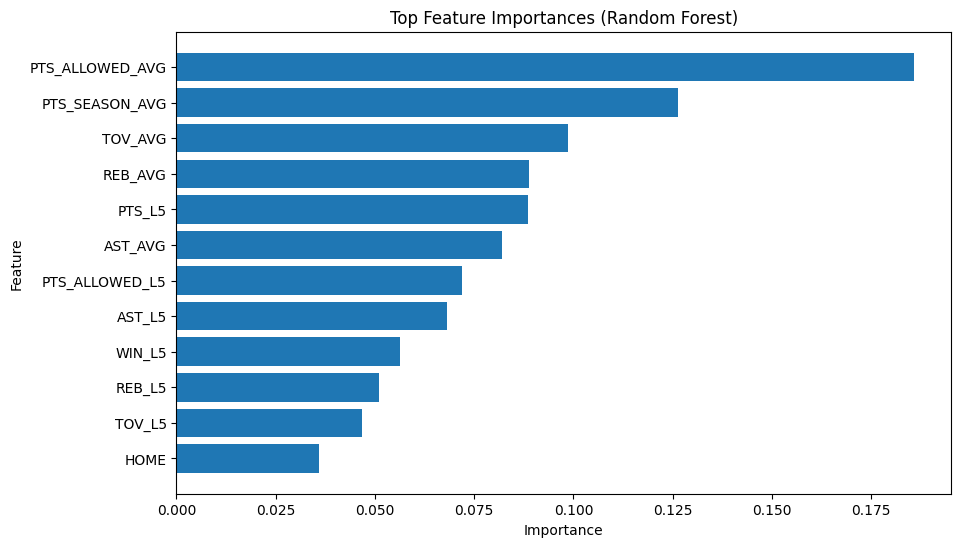

In [14]:
top_n = 12

plt.figure(figsize=(10, 6))
plt.barh(
    rf_importance.head(top_n)['Feature'],
    rf_importance.head(top_n)['Importance']
)
plt.gca().invert_yaxis()
plt.title('Top Feature Importances (Random Forest)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()


# Error Analysis

In [15]:
# Sort teams by absolute error
comparison_sorted = comparison.sort_values('ERROR')

# Most under-predicted teams
comparison_sorted.head(5)


,TEAM_ABBREVIATION,PROJECTED_WINS,ACTUAL_WINS,ERROR
0,OKC,48.768213,63,-14.231787
2,CLE,44.916421,59,-14.083579
1,BOS,47.410548,57,-9.589452
14,IND,38.499719,48,-9.500281
17,MEM,36.836113,46,-9.163887


In [16]:
# Most over-predicted teams
comparison_sorted.tail(5)


,TEAM_ABBREVIATION,PROJECTED_WINS,ACTUAL_WINS,ERROR
23,PHI,31.974527,23,8.974527
6,MIA,43.284401,34,9.284401
20,BKN,33.481154,24,9.481154
21,NOP,32.079495,19,13.079495
22,CHA,31.975596,17,14.975596


# Visualizations
Projected vs Actual Wins: There are some overpredictions, but alot more under predictions reinforcing ideas that player and team development are harder

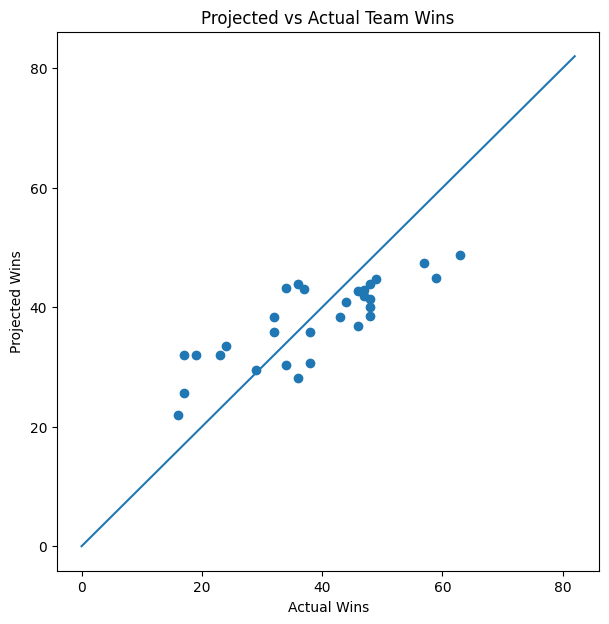

In [17]:
plt.figure(figsize=(7, 7))
plt.scatter(
    comparison['ACTUAL_WINS'],
    comparison['PROJECTED_WINS']
)
plt.plot([0, 82], [0, 82])  # perfect prediction line
plt.xlabel('Actual Wins')
plt.ylabel('Projected Wins')
plt.title('Projected vs Actual Team Wins')
plt.show()


Error Distribution

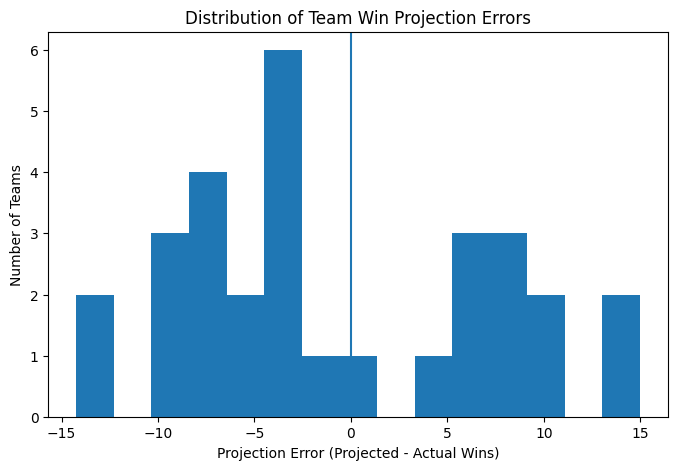

In [18]:
plt.figure(figsize=(8, 5))
plt.hist(comparison['ERROR'], bins=15)
plt.axvline(0)
plt.xlabel('Projection Error (Projected - Actual Wins)')
plt.ylabel('Number of Teams')
plt.title('Distribution of Team Win Projection Errors')
plt.show()


# Feature groups

In [19]:
rf_importance['Feature_Group'] = rf_importance['Feature'].apply(
    lambda x: 'Rolling (Last 5)'
    if '_L5' in x else 'Season-to-Date'
)

group_importance = (
    rf_importance
    .groupby('Feature_Group')['Importance']
    .sum()
    .reset_index()
)

group_importance


,Feature_Group,Importance
0,Rolling (Last 5),0.382639
1,Season-to-Date,0.617361


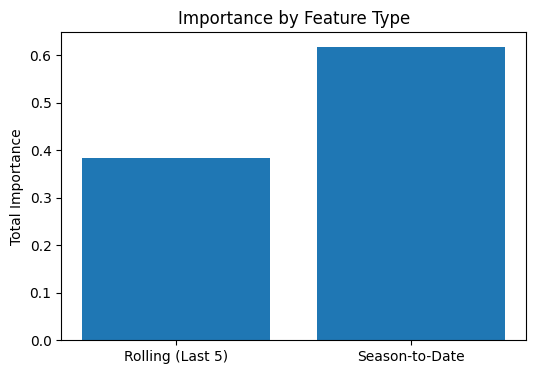

In [20]:
plt.figure(figsize=(6, 4))
plt.bar(group_importance['Feature_Group'], group_importance['Importance'])
plt.title('Importance by Feature Type')
plt.ylabel('Total Importance')
plt.show()


# Error Analysis: Over- and Under-Predicted Teams

**Most Under-Predicted Teams**
| Team | Projected Wins | Actual Wins | Error |
| ---- | -------------- | ----------- | ----- |
| OKC  | 48.8           | 63          | −14.2 |
| CLE  | 44.9           | 59          | −14.1 |
| BOS  | 47.4           | 57          | −9.6  |
| IND  | 38.5           | 48          | −9.5  |
| MEM  | 36.8           | 46          | −9.2  |


Interpretation:

- These teams significantly outperformed expectations based on prior-season and early-season statistics.

Common factors the model does not capture:
- Breakout player development (e.g., OKC’s young core accelerating faster than historical averages).
- Improved defensive efficiency or coaching changes not directly reflected in basic team stats.
- In-season continuity and health advantages.

OKC and Cleveland in particular highlight a core limitation of team-stat models: they struggle to anticipate non-linear improvements driven by player growth rather than historical averages.

**Most Over-Predicted Teams**
| Team | Projected Wins | Actual Wins | Error |
| ---- | -------------- | ----------- | ----- |
| PHI  | 32.0           | 23          | +9.0  |
| MIA  | 43.3           | 34          | +9.3  |
| BKN  | 33.5           | 24          | +9.5  |
| NOP  | 32.1           | 19          | +13.1 |
| CHA  | 32.0           | 17          | +15.0 |


Interpretation:

- These teams underperformed relative to statistical expectations.

Likely drivers of error:

- Injuries and missed games (e.g., PHI, NOP).

- Roster instability or trades (BKN).

- Young or inconsistent lineups where early-season stats overstated true strength (CHA).

- The model assumes availability and stability, which breaks down when injuries or rotations fluctuate heavily.

**Feature Importance Interpretation**
| Feature Group          | Total Importance |
| ---------------------- | ---------------- |
| Season-to-Date         | **0.62**         |
| Rolling (Last 5 Games) | **0.38**         |

Key Takeaways:

- Season-to-date metrics dominate, indicating the model primarily relies on longer-term team strength signals rather than short-term streaks.

- Rolling features still contribute meaningfully, confirming that recent momentum matters, but does not override broader team quality.

This explains why:

- Breakout teams were underpredicted (historical averages lag real improvement).

- Injury-prone teams were overpredicted (prior stats assume full availability).

**Model Strengths & Limitations**

What the Model Does Well:

- Correctly identifies tier structure across the league.

- Differentiates strong vs weak teams using only team-level stats.

- Produces interpretable errors rather than random noise.

Where It Struggles:

- Cannot anticipate:

  - Player-level development

  - Injuries and missed games

  - Mid-season trades

  - Season-long projections amplify early misestimates.


**Final Insight**

Historical and rolling team statistics provide meaningful signal for forecasting NBA game outcomes and season-level performance. While the model captures league-wide trends and relative team strength, its largest errors arise from factors outside team-level box score metrics, such as injuries, roster changes, and player development.

These results highlight both the value and limitations of purely statistical approaches and suggest clear pathways for improvement through player-level data and availability modeling. In real-world applications such as sports betting and analytics platforms, insights like these can inform line setting, risk management, and confidence weighting by identifying when model-driven projections should be adjusted for contextual factors beyond historical performance.